In [ ]:
%%capture
%env TF_CPP_MIN_LOG_LEVEL=1  # Disable logs on TF import

In [ ]:
!pip install -q tfds-nightly
!tfds --version

In [ ]:
import os
os.chdir('./drive/MyDrive/T-shirtProject/Tshirt_dataset')
os.getcwd()

In [ ]:
!tfds build --overwrite

In [ ]:
import tensorflow_datasets as tfds
ds_orig,info=tfds.load('Tshirt_dataset',
                shuffle_files=True,
                as_supervised=True,  
                with_info=True)
info
ds_train_orig=ds_orig['train']
ds_test_orig=ds_orig['test']

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

for image,label in ds_train_orig.take(1):
    print(image.shape)
    print(label.shape)

    print(label.shape)
    #print image
    plt.imshow(image)


In [ ]:
ds_train=ds_train_orig.map(lambda image,label: (image/255,label))
ds_train=ds_train.cache()
ds_train=ds_train.shuffle(1000)
ds_train=ds_train.batch(128)
ds_test=ds_test_orig.map(lambda image,label: (image/255,label))
ds_test=ds_test.cache()
ds_test=ds_test.batch(128)


In [ ]:
from tensorflow.keras import models, layers
from tf_fourier_features import FourierFeatureProjection
import pickle
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(108,192,3)))


model.add(FourierFeatureProjection(gaussian_projection = 256, gaussian_scale = 15.0))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(72,(3,3),padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(108,(3,3),padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(164,(3,3),padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(242,(3,3),padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(363,(3,3),padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2,2)))





model.add(layers.Flatten())
#outputlayer is a tensor of shape (n,2704,3)
model.add(layers.Dense(2704*3))
model.add(layers.Reshape((2704,3)))

model.summary()

model.compile(  optimizer='adam',
                loss='mse',
                metrics=['mae'])

history=model.fit(  ds_train,
                    epochs=1000,
                    validation_data=ds_test)

model.save("T-shirtmodel.keras")


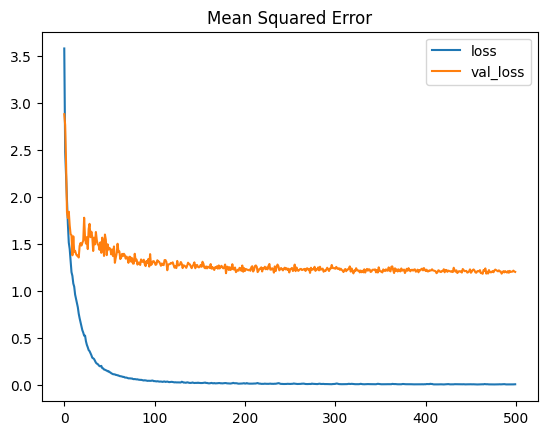

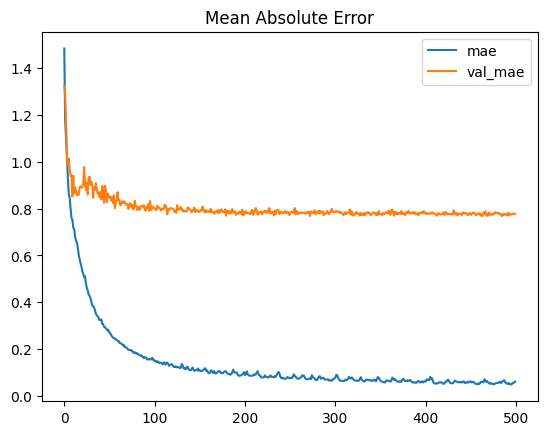

In [ ]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Mean Squared Error")
    plt.show()
    plt.close()

    plt.plot(history["mae"], label="mae")
    plt.plot(history["val_mae"], label="val_mae")
    plt.legend()
    plt.title("Mean Absolute Error")
    plt.show()
    plt.close()

render_history(model.history.history)

In [ ]:
import json
#test the model
index=0
for image,label in ds_test_orig.take(10):
    print(image.shape)
    print(label.shape)
    #print image
    plt.imshow(image)
    #predict
    prediction=model.predict(image[np.newaxis,...]/255)
    print(prediction.shape)

    with open('prediction'+str(index), 'w') as f:
        json.dump(prediction.tolist(), f)
    #print prediction
 
    plt.show()
    plt.savefig('img'+str(index)+'.png')
    index+=1

